# Classification
This notebook is written for author classification. The main objective of classification is to build a model based on researchers’ publications to predict whether he/she would get the sack after the repression of the coup. 

This author classification problem mentioned above is a bi-classification problem. We plan to prepare the author's data of each category and use supervised-learning method to train a model and solve the classification task.

Classification (supervised-learning) model used include:
1. Logistic regression;
2. Neural networks.

The data is obtained by web scraping from [Web of Science](http://apps.webofknowledge.com/WOS_GeneralSearch_input.do?product=WOS&search_mode=GeneralSearch&SID=F41mtBBV1mNZKmygFN7&preferencesSaved=) using extended version of web of science. The search strategy is searching the full family name + first letter of given name (e.g. For some one ’Tom Smith’ we search ‘Smith T\*’). Therefore, the data we scraped is quite implicit, we have to preprocess it to obtain explicit data and extract suitable features before using it to train models. 

Feature extraction methods used include:

1. Word2vec;
2. Bag-of-words;
3. Fasttext.

In [2]:
# Other package:
import re
import pickle
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import io

# Math packages
import numpy as np
import pandas as pd

# NPL package: gensim
import gensim

# Machine learning packeage: sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Deep learning package: keras
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

Using TensorFlow backend.


## 0. Load Data
### 0.1 Load Dismissed Author List
We load the already known **dismissed author list**, which can be treated as ground truth. The list contains:
- `Author` name and corresponding `Affiliation`.
- We split data (string), extract author name and affiliation information and use `pandas.DataFrame` to wrap it.

In [2]:
# Load the already known dismissed author list
searchnames_dismiss_univ = []
searchnames_dismiss_fullname = []

for line in open('./data/Dismis_Acad_List_CLEAN.txt','r'): 
    QueryString = line.strip()
    QueryString_aff = QueryString.split(',')[1]
    # Change the order of author's name as: family name, first name,  middle name
    QueryString_fullname = QueryString.split(',')[0].split()[-1] + ' '\
                                + ' '.join(QueryString.split(',')[0].split()[0:-1])
    searchnames_dismiss_fullname.append(QueryString_fullname)
    searchnames_dismiss_univ.append(QueryString_aff)
    
# Wrap the dismissed author list to Dataframe    
auth_aff_df = pd.DataFrame({'Author':searchnames_dismiss_fullname,
                            'Affiliation':searchnames_dismiss_univ})
# Display pre-processed data after second stage
auth_aff_df.head(2)

,Author,Affiliation
0,AYDIN AYDIN,SULEYMAN DEMIREL UNIVERSITY
1,GILGIL ERDAL,AKDENIZ UNIVERSITY


### 0.2  Load Scraped Dismissed and Undismissed Authors Data
We load the paper data of dismissed authors and undismissed authors scraped from [Web of Science](http://apps.webofknowledge.com/WOS_GeneralSearch_input.do?product=WOS&search_mode=GeneralSearch&SID=F41mtBBV1mNZKmygFN7&preferencesSaved=) and parse it into `pandas.DataFrame` format which contains features as below, the parsing code is stored in file `Parsing.py`: 
- Paper info: uid, doctype, title, language, key words, subject, heading, subheading.
- Publishment info: source, publish date, pubtype.
- Author info: name, affiliation.

**Actually, this part is NOT reproducible, because we cannot share the data for the sake of privacy! Please jump to the `1.Data Pre-processing`.**

In [3]:
# Load data of dismissed authors
data_dismiss = pd.read_csv('./data/dismissed_complete.csv')
data_dismiss.head(2)

FileNotFoundError: File b'./data/dismissed_complete.csv' does not exist

In [4]:
# Load data of undismissed authors for Word2vec and Bag-of-words
with open('./data/not_dismissed_dataset.pickle', 'rb') as handle:
    data_not_dismiss = pickle.load(handle)
data_not_dismiss.head(2)

,FullName,abstract,category_info,doctype,issue,keywords,language,name_info,publish_date,pubtype,source,title,uid,vol
0,Eroglu Ilhan,"In this research, the performance of inflation...","{'headings': ['Social Sciences'], 'subheadings...",Article,1,"[Inflation, inflation targeting, price stabili...",[English],"{'Eroglu, Ilhan': {'daisng_id': '11528418', 'r...",2017-06-28,Journal,ECONOMIC RESEARCH-EKONOMSKA ISTRAZIVANJA,An evaluation of the effectiveness of an infla...,WOS:000414188100001,30
1,Eroglu Ilhan,"Following the 2008 global financial crisis, th...","{'headings': ['Social Sciences'], 'subheadings...",Article,1,"[Financial crisis, interest rate, budget defic...",[English],"{'Temur, Yusuf': {'daisng_id': '20997302', 'ro...",2017-01-01,Journal,ECONOMIC RESEARCH-EKONOMSKA ISTRAZIVANJA,Identifying relationship between macroeconomic...,WOS:000400797200001,30


## 1. Data Pre-processing
Data scraped from [Web of Science](http://apps.webofknowledge.com/WOS_GeneralSearch_input.do?product=WOS&search_mode=GeneralSearch&SID=F41mtBBV1mNZKmygFN7&preferencesSaved=) is unavoidably messy, we have to pre-process the data before we utilize it. We wrap each author name and all his matched papers (put those data to a `pandas.DataFrame` format) as one key-value pair of dictionary, such as {Author: Paper_DataFrame}.

The following is the data obtained after pre-processing, load it to skip data pre-processing and get results directly.

In [ ]:
with open('./data/not_dis_author_dict.pickle', 'rb') as handle:
    not_dis_author_dict = pickle.load(handle)
    
with open('./data/author_explict_dict.pickle', 'rb') as handle:
    author_explict_dict = pickle.load(handle)
    
# Those two datasets are generated by Undis_List_Generation_for_FastText.ipynb
not_dis_author_dict_fasttext = pd.read_csv('./data/no_dis_auth_vec_2.csv')
total_no_dis_pub = pd.read_csv('./Data/total_no_dis_pub_2.csv')

### 1.1 Dismissed Author List Pre-processing
Process **dismissed author list**:
- Get the abbreviation names of authors in **dismissed author list** (e.g. using 'AYDIN A.' to represent 'AYDIN AYDIN').
- Drop 'bad' names such as names with only family name or with more than three words, which only account for less than 1% of all names.
- We find most authors in **dismissed author list** have 'UNIVERSITY' as the end of their `Affiliation` (>99%), we drop those authors whose `Affiliation` does not end with 'UNIVERSITY'. Change 'UNIVERSITY' in `Affiliation` to 'UNIV' for the simplity of following matching.

In [5]:
def get_abbreviation(x):
    '''
    Get the abbreviation name by giving the full name.
    
    Input:
        x: string - A full name.
        
    Return:
        Return an abbreviation name.
    '''
    x_abbr = x.split(' ')[0] + ' '
    # Not only 1 word in name
    if len(x.split(' ')[-1])!=0:
        for i in range(1, len(x.split(' '))):
            x_abbr =  x_abbr + x.split(' ')[i][0] 
    else:
        x_abbr = np.nan
    return x_abbr

In [6]:
# Add explicit Abbrname: Two guys only has his family name in list, we drop it
auth_aff_df['Author_Abbr_explicit'] = auth_aff_df['Author'].map(lambda x: get_abbreviation(x)).values

# Add implicit Abbrname: Used for rough selection
auth_aff_df['Author_Abbr_implicit'] = auth_aff_df['Author'].map(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1][0] + '*'\
                                                           if len(x.split(' ')[-1])!=0 else np.nan).values
auth_aff_df.dropna(inplace=True)

# Drop guys with four or more words in their name, actually only 23 of it
auth_aff_df['Author'] = auth_aff_df['Author'].map(lambda x:np.nan if len(x.split(' '))>3 else x)
auth_aff_df.dropna(inplace=True)

In [7]:
# We find most data in dismissed author list has ‘UNIVERSITY’ as the end of 'Affiliation'
indication_var = auth_aff_df.Affiliation.str.contains('.*UNIVERSITY$')
rate = np.sum(indication_var) / auth_aff_df.shape[0]
print('Rate of Affiliation end with UNIVERSITY: {:.5f}'.format(rate))
auth_aff_df[indication_var.map(lambda x: not x)]

Rate of Affiliation end with UNIVERSITY: 0.99775


,Author,Affiliation,Author_Abbr_explicit,Author_Abbr_implicit
344,NESLITURK ALI IHSAN,IZMIR YUKSEL TEKNOLOJI ENS.,NESLITURK AI,NESLITURK A*
1140,OZATAGAN GULDEM,IZMIR YUKSEK TEKNOLOJI ENS,OZATAGAN G,OZATAGAN G*
1779,PENCECIOGLU MEHMET,IZMIR YUKSEK TEKNOLOJI ENS,PENCECIOGLU M,PENCECIOGLU M*
2159,KOKSAL MUSTAFA,IZMIR YUKSEL TEKNOLOJI ENS.,KOKSAL M,KOKSAL M*
2699,AFYON SEMIH,IZMIR YUKSEL TEKNOLOJI ENS.,AFYON S,AFYON S*
3056,YAYLAR YASIN,AHI EVRAN UV,YAYLAR Y,YAYLAR Y*
3304,OZTURK OZGUR,IZMIR YUKSEL TEKNOLOJI ENS.,OZTURK O,OZTURK O*
3568,BOYLU SUKRU,ADNAN MENDERES UV,BOYLU S,BOYLU S*


In [8]:
# Change to UNIV
auth_aff_df['Affiliation'] = auth_aff_df['Affiliation'].map(lambda x: x.replace('UNIVERSITY', 'UNIV')\
                                                                if 'UNIVERSITY' in x else x)
auth_aff_df.head(2)

,Author,Affiliation,Author_Abbr_explicit,Author_Abbr_implicit
0,AYDIN AYDIN,SULEYMAN DEMIREL UNIV,AYDIN A,AYDIN A*
1,GILGIL ERDAL,AKDENIZ UNIV,GILGIL E,GILGIL E*


### 1.2 Dismissed Data Pre-processing
For **Dismissed Data**, we apply methods as follow **first**:
- Since some authors may collaborate on papers, some rows in the Paper DataFrame might be same. We drop the duplicated rows in the Paper DataFrame.
- Author info features(such as `keywords` and `name_info`) are in string, we spilt them and turn them into dict and list.
- Turn `keywords` features into lower case.

In [9]:
data_dismiss = data_dismiss.rename(columns = {'subheadind':'subheading'})
# Some authors may have same papers, drop them
data_dismiss.drop_duplicates(inplace=True)

# Change string data to dict and list
data_dismiss['name_info'] = data_dismiss.name_info.map(lambda x: eval(x)).values
data_dismiss['keywords'] = list(map(lambda x: eval(x) if type(x)==type('string') else x, \
                                    data_dismiss.keywords.values.tolist()))
# Turn key words into lower case
keyword_dup_bypaper = []
for keywords_list in data_dismiss.keywords.values:
    if str(keywords_list)!='nan':
        keyword_dup_bypaper.append([x.lower() for x in keywords_list])
    else:
        keyword_dup_bypaper.append(keywords_list)
data_dismiss['keywords'] = keyword_dup_bypaper

# Display pre-processed data after first stage
data_dismiss.head(2)

,doctype,keywords,language,name_info,publish_date,pubtype,source,title,AbbrNames,uid,heading,subheading,traditional_sub,extended_sub
0,Article,"[coal, geostatistics, kriging, turkey, variogram]",['English'],"{'DEMIREL I*': {'daisng_id': '1674276', 'role'...",2000-12-01,Journal,ENERGY SOURCES,Geostatistical reserve estimation: A case stud...,"['DEMIREL I*', 'SARAC C*', 'SEN O*']",WOS:000165681500009,['Science & Technology'],['Technology'],"['Energy & Fuels', 'Engineering, Chemical']","['Energy & Fuels', 'Engineering']"
1,Article,"[ozone, pulp bleaching, pretreatment, algal tr...",['English'],"{'BALCIOGLU I*': {'daisng_id': '897760', 'role...",2006-12-01,Journal,OZONE-SCIENCE & ENGINEERING,Application of ozonation and biotreatment for ...,"['BALCIOGLU I*', 'SARAC C*', 'KIVILCIMDAN C*',...",WOS:000242899300005,['Science & Technology'],"['Technology', 'Life Sciences & Biomedicine']","['Engineering, Environmental', 'Environmental ...","['Engineering', 'Environmental Sciences & Ecol..."


**Secondly**, since some authors of papers are represented in abbreviation names (e.g. using 'AYDIN A.' to represent 'AYDIN AYDIN'), we can not just search full names to have paper results, which obviously will ignore some necessary papers. In order to avoid such problem, we use abbreviation names of authors to search paper results and scrape data.

However, the data scraped by abbreviation names can contain lots of papers written by researchers having the same abbreviation names. To select corresponding papers of specific authors in data:
- We match papers to authors in **dismissed author list** by `display_name` and `organization`.
- If one paper has an author with the same `display_name` and `organization` as one in **dismissed author list**, we regard it as the matched paper and match it to this author.
- Then we wrap each author name and all his matched papers(`pandas.DataFrame`) as one key-value pair of dictionary, such as `{Author: Paper_DataFrame}`.

In [10]:
def match_fullname_affiliation(Affiliation, Author, Author_Abbr_implicit, Author_Abbr_explicit, Author_Abbr_matched_set):
    '''
    Match full names and affiliations of items in dismissed author list.
    
    Input:    
        Affiliation: Affiliations of authors in dismissed author list.
        Author: Names of authors in dismissed author list.
        Author_Abbr_implicit: Used for explicit match.
        Author_Abbr_explicit: Used for rough selection.
        Author_Abbr_matched_set: Dismissed author list.
        
    Return:
        Wrap matched papers data to a pandas.DataFrame and return it.
    '''
    explicit_set = []
    for i in range(Author_Abbr_matched_set.shape[0]):
        try:
            address = Author_Abbr_matched_set.iloc[i]['name_info'][Author_Abbr_implicit]['address']['organization'].upper()
            # full name
            display_name_opt1 = Author_Abbr_matched_set.iloc[i]['name_info'][Author_Abbr_implicit]['display_name'].upper().replace(',','')
            # Abbrevation:
            # 1. Because we drop all names >3 words in auth_aff_df, so we only consider name with lenth<=3 in data_dismiss. 
            # 2. The corresponding second word in Abbrevation of data_dismiss at most contain 2 letters:
            # Possible format: ['Jack Jay Mike']: 'Jack J. Mike', 'Jack J. M.', 'Jack J.'
            display_name_opt2 = get_abbreviation(display_name_opt1)\
                if len(display_name_opt1.split(' ')[1])<=2 and 0<len(display_name_opt1.split(' ')[1]) else display_name_opt1
            # If one item (paper) has same full name and affiliation as in List
            if address == Affiliation and (display_name_opt1 == Author or display_name_opt2 == Author_Abbr_explicit):
                explicit_set.append(True)
            else:
                explicit_set.append(False)
        except:
            explicit_set.append(False)
    return Author_Abbr_matched_set[explicit_set]

In [11]:
# Dictionary used to store author's paper data in format: {Author: Paper_DataFrame}.
author_explict_dict = {}
for i in range(auth_aff_df.shape[0]):
    Author_Abbr_implicit = auth_aff_df.iloc[i]['Author_Abbr_implicit']
    Author_Abbr_explicit = auth_aff_df.iloc[i]['Author_Abbr_explicit']
    Author = auth_aff_df.iloc[i]['Author']
    Affiliation = auth_aff_df.iloc[i]['Affiliation']
    # Add ' before Author_Abbr to ensure that it will not be matched to words that luckily contains it
    Author_Abbr_match = '\'' + Author_Abbr_implicit.strip('*') + '\*'
    # Get the Author_Abbr_matched_set, which is got by matching AbbrNames to Author_Abbr_implicit
    indication_var = data_dismiss['AbbrNames'].str.contains(Author_Abbr_match)
    Author_Abbr_matched_set = data_dismiss[indication_var]
    # Match full names and affiliations of items in Author_Abbr_matched_set 
    explicit_set = match_fullname_affiliation(Affiliation, 
                                              Author, 
                                              Author_Abbr_implicit, 
                                              Author_Abbr_explicit, 
                                              Author_Abbr_matched_set)
    if explicit_set.shape[0] != 0:
        author_explict_dict.update({Author: {'BasicData':explicit_set}})
# Show example of dictionary item
author_explict_dict['TAKTAK SUKRU']['BasicData'].head(2)

,doctype,keywords,language,name_info,publish_date,pubtype,source,title,AbbrNames,uid,heading,subheading,traditional_sub,extended_sub
43524,Article,"[trd chromizing, plasma nitriding, duplex trea...",['English'],"{'TAKTAK S*': {'daisng_id': '1323449', 'role':...",2008-04-15,Journal,SURFACE & COATINGS TECHNOLOGY,High temperature wear and friction properties ...,"['TAKTAK S*', 'ULKER S*', 'GUNES I*']",WOS:000254867700030,['Science & Technology'],"['Technology', 'Physical Sciences']","['Materials Science, Coatings & Films', 'Physi...","['Materials Science', 'Physics']"
43544,Proceedings Paper,"[borided layer, fracture toughness, boriding, ...",['English'],"{'FRACKOWIAK M*': {'daisng_id': '27655463', 'r...",2018-01-01,Book in series,ADVANCES IN MANUFACTURING (MANUFACTURING 2017),Fracture Toughness of Plasma Paste-Borided Lay...,"['FRACKOWIAK M*', 'MAKUCH N*', 'DZIARSKI P*', ...",WOS:000441196700089,['Science & Technology'],['Technology'],"['Engineering, Industrial', 'Engineering, Manu...",['Engineering']


In [12]:
print('Final dismissed Author number:', len(author_explict_dict.keys()))

Final dismissed Author number: 2004


The final dismissed author number in dictionary is less than the author number in **dismissed author list**, for the sake of following reasons:
- Some authors in **dismissed author list** do not have paper data in [Web of Science](http://apps.webofknowledge.com/WOS_GeneralSearch_input.do?product=WOS&search_mode=GeneralSearch&SID=F41mtBBV1mNZKmygFN7&preferencesSaved=). 
- Some authors in **dismissed author list** do not have `display_name` and `organization` features in [Web of Science](http://apps.webofknowledge.com/WOS_GeneralSearch_input.do?product=WOS&search_mode=GeneralSearch&SID=F41mtBBV1mNZKmygFN7&preferencesSaved=), which cannot be matched by `display_name` and `organization`.
- Some papers do have `organization` features. However, these `organization` features contain addresses of all authors of paper and do not give a explicit corresponding relationship that tells which address is belong to which author .

### 1.3 Undismissed Data Pre-processing
For **Undismissed Data**, we apply methods as follow **first**:
- The undismissed data and dismissed data are scraped by different groups and have different formats. First, we arrange the undismissed data to the same format as dismissed data.
- Turn keywords features into lower case.

In [13]:
# Process data_not_dismiss to make it in same format as data_dismiss
data_not_dismiss['heading'] = data_not_dismiss['category_info'].map(lambda x: x['headings'])
data_not_dismiss['subheading'] = data_not_dismiss['category_info'].map(lambda x: x['subheadings'])
data_not_dismiss['traditional_sub'] = data_not_dismiss['category_info'].map(lambda x: x['traditional_subjects'])
data_not_dismiss['extended_sub'] = data_not_dismiss['category_info'].map(lambda x: x['extended_subjects'])
data_not_dismiss['keywords'] = data_not_dismiss['keywords'].map(lambda x: np.nan if len(x)==0 else x)

# Change format of key of name_info
for i in range(data_not_dismiss.shape[0]):
    keys = list(data_not_dismiss.name_info[i].keys())
    keys_change = list(map(lambda x: x.replace(',', ''), keys))
    for j in range(len(keys_change)):
        data_not_dismiss.name_info[i].update({keys_change[j]:data_not_dismiss.name_info[i].pop(keys[j])})
        
# Turn keywords features into lower case.
keyword_dup_bypaper = []
for keywords_list in data_not_dismiss.keywords.values:
    if str(keywords_list)!='nan':
        keyword_dup_bypaper.append([x.lower() for x in keywords_list])
    else:
        keyword_dup_bypaper.append(keywords_list)
data_not_dismiss['keywords'] = keyword_dup_bypaper
data_not_dismiss = data_not_dismiss[['doctype', 'keywords', 'language',
                                     'name_info', 'publish_date', 'pubtype',
                                     'source', 'title', 'FullName', 
                                     'uid', 'heading', 'subheading',
                                     'traditional_sub', 'extended_sub']]
data_not_dismiss_origin = data_not_dismiss.copy()
data_not_dismiss.head(2)

,doctype,keywords,language,name_info,publish_date,pubtype,source,title,FullName,uid,heading,subheading,traditional_sub,extended_sub
0,Article,"[inflation, inflation targeting, price stabili...",[English],"{'Eroglu Ilhan': {'daisng_id': '11528418', 'ro...",2017-06-28,Journal,ECONOMIC RESEARCH-EKONOMSKA ISTRAZIVANJA,An evaluation of the effectiveness of an infla...,Eroglu Ilhan,WOS:000414188100001,[Social Sciences],None,[Economics],[Business & Economics]
1,Article,"[financial crisis, interest rate, budget defic...",[English],"{'Temur Yusuf': {'daisng_id': '20997302', 'rol...",2017-01-01,Journal,ECONOMIC RESEARCH-EKONOMSKA ISTRAZIVANJA,Identifying relationship between macroeconomic...,Eroglu Ilhan,WOS:000400797200001,[Social Sciences],None,[Economics],[Business & Economics]


**Secondly**, since the undismissed data is scraped according to the names of coauthors of dismissed authors, it may contain lots of coauthors who do not even come from Turkey. We do pre-processes as below:
- If one paper has an author who has `country` attribute and its value is **Turkey**, we regard it as one paper of undismissed authors.
- The paper data scraped from [Web of Science](http://apps.webofknowledge.com/WOS_GeneralSearch_input.do?product=WOS&search_mode=GeneralSearch&SID=F41mtBBV1mNZKmygFN7&preferencesSaved=) of one undismissed author may be the same as another dissmissed author (e.g. one dissmissed author and another undismissed author are coauthers and both of them only have 1 same paper in [Web of Science](http://apps.webofknowledge.com/WOS_GeneralSearch_input.do?product=WOS&search_mode=GeneralSearch&SID=F41mtBBV1mNZKmygFN7&preferencesSaved=)). In order to avoid that undismissed data have same items as dismissed data, we only select undismissed authers having **more than 5 papers**.
- Then we wrap each author name and all his matched papers(`pandas.DataFrame`) as one key-value pair of dictionary, such as `{Author: Paper_DataFrame}` as before.

In [14]:
# Select author in not dismissed list who is from Turkey
for i in range(data_not_dismiss.shape[0]):
    try:
        fullname = data_not_dismiss['FullName'][i]
        name_info = data_not_dismiss['name_info'][i][fullname]
        if name_info['address']['country'] != 'Turkey':
            data_not_dismiss['name_info'][i] = np.nan
    except:
        data_not_dismiss['name_info'][i] = np.nan
data_not_dismiss.dropna(subset=['name_info'], inplace=True)

In [15]:
# Put author data in to a dict and use his name as key
not_dis_author_dict = {}
for author in data_not_dismiss.FullName.unique():
    author_df = data_not_dismiss[data_not_dismiss['FullName'] == author]
    # Only select those have more than 5 papers
    if author_df.shape[0]>5:
        not_dis_author_dict.update({author: {'BasicData':author_df}})
auth_aff_df.loc[auth_aff_df.Author=='TAKTAK SUKRU']
not_dis_author_dict['Koksal Deniz']['BasicData'].head(2)

,doctype,keywords,language,name_info,publish_date,pubtype,source,title,FullName,uid,heading,subheading,traditional_sub,extended_sub
5,Meeting Abstract,"[bronchoscopy, lung cancer / oncology, thoraci...",[English],"{'Ozturk Ozge': {'daisng_id': None, 'role': 'a...",2015-09-01,Journal,EUROPEAN RESPIRATORY JOURNAL,Diagnostic value of conventional transbronchia...,Koksal Deniz,WOS:000451979404161,[Science & Technology],[Life Sciences & Biomedicine],[Respiratory System],[Respiratory System]
6,Correction,NaN,[English],"{'Abbas Sherif': {'daisng_id': '6248113', 'rol...",2018-10-01,Journal,JOURNAL OF BIOMEDICAL OPTICS,Diagnosis of malignant pleural mesothelioma fr...,Koksal Deniz,WOS:000449335800026,[Science & Technology],"[Life Sciences & Biomedicine, Physical Sciences]","[Biochemical Research Methods, Optics, Radiolo...","[Biochemistry & Molecular Biology, Optics, Rad..."


In [16]:
print('Final undismissed Author number:', len(not_dis_author_dict.keys()))

Final undismissed Author number: 2347


In [17]:
# Save the dictionary
# with open('./data/author_explict_dict.pickle', 'wb') as handle:
#     pickle.dump(author_explict_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('./data/not_dis_author_dict.pickle', 'wb') as handle:
#     pickle.dump(not_dis_author_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# Load data of undismissed authors for FastTest, which has been pre-processed
# Those two datasets are generated by Undis_List_Generation_for_FastText.ipynb
not_dis_author_dict_fasttext = pd.read_csv('./data/no_dis_auth_vec_2.csv')
total_no_dis_pub = pd.read_csv('./Data/total_no_dis_pub_2.csv')

## 2.  Feature Extraction
We only use `keywords` in data as features to represent a paper. However, the `keywords` of papers are words and we use methods to find numerical representations for words as below:

1. Word2vec;
2. Bag-of-words;
3. Fasttext.

The following is the data obtained after feature selection, load it to skip data feature extraction (very time-consuming) and get results directly.

In [ ]:
# Features extraction by Word2vec
with open('./data/X_keyword_vector.pickle', 'rb') as handle:
    X_keyword_vector = pickle.load(handle)
with open('./data/y_keyword_vector.pickle', 'rb') as handle:
    y_keyword_vector = pickle.load(handle)
    
# Features extraction by Bag-of-words
with open('./data/X_bag_of_words.pickle', 'rb') as handle:
    X_bag_of_words = pickle.load(handle)
with open('./data/y_bag_of_words.pickle', 'rb') as handle:
    y_bag_of_words = pickle.load(handle)
    
# Features extraction by fasttext
with open('./data/X_set1_fasttext.pickle', 'rb') as handle:
    X_set1_fasttext = pickle.load(handle)
with open('./data/y_set1_fasttext.pickle', 'rb') as handle:
    y_set1_fasttext = pickle.load(handle)
with open('./data/X_set2_fasttext.pickle', 'rb') as handle:
    X_set2_fasttext = pickle.load(handle)
with open('./data/y_set2_fasttext.pickle', 'rb') as handle:
    y_set2_fasttext = pickle.load(handle)

### 2.1 Word2vec
>[Word2vec](https://en.wikipedia.org/wiki/Word2vec) is a group of related models that are used to produce word embeddings. It takes as its input a large **corpus of text** and produces a vector space, with each unique word in the corpus being assigned a corresponding vector. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.

We create **Word2vec** model as below:

**First**:
- We construct **corpus of text** by combining all the `keywords` of undismissed authors and dismissed authors. Then, train the model and embed `keywords` to 32 dimensions space. 

In [19]:
# Combine all keywords in data_dismiss and data_not_dismiss
def get_keyword_list(dataframe):
    keyword_list = []
    for i in range(dataframe.shape[0]):
        key_words = dataframe['keywords'].iloc[i]
        if str(key_words) != 'nan' and key_words != None:
            keyword_list.append(key_words)
    return keyword_list

# Load data of undismissed authors
keyword_bypaper_dis = get_keyword_list(data_dismiss)
keyword_bypaper_undis = get_keyword_list(data_not_dismiss_origin)
    
keyword_bypaper = keyword_bypaper_dis.copy()
keyword_bypaper.extend(keyword_bypaper_undis)

# Train word2vec model
model = gensim.models.Word2Vec(keyword_bypaper, min_count=1, size=32)
model.save("./data/word2vec.model")
# model = gensim.models.Word2Vec.load("./data/word2vec.model")

A simple way to investigate the learned representations is to find the closest words for a specified word. To test the performance of our model, we show an example of a given word 'parkinson disease':

In [20]:
model.similar_by_word('parkinson disease')

[('resting-state', 0.9944981336593628),
 ('resting-state fmri', 0.9944922924041748),
 ('epileptic seizures', 0.9943488836288452),
 ('electrical stimulation', 0.9942954778671265),
 ('prepulse inhibition', 0.9940583109855652),
 ('medial prefrontal cortex', 0.9935349225997925),
 ('brain imaging', 0.9935184121131897),
 ('motor coordination', 0.9932699799537659),
 ('primary motor cortex', 0.9930866360664368),
 ('deep brain-stimulation', 0.9925353527069092)]

And the close words are highly related to parkinson disease(e.g. brain imaging is widely used in PD diagnosis) so the model is good.

In [21]:
model.similarity('parkinson disease','brain imaging')

0.9935185216443656

**Secondly**:
- We take **average of all word vectors** of one paper and regard this average word vector as keyword vector feature of the paper. 
- If one author have more than one paper data, we take **average of word vectors** (calculated above) of all papers and regard this average word vector as **keyword vector feature** of the author.
- Then we wrap each author name and his **keyword vector feature** as one key-value pair of dictionary, such as `{Author: KeywordVector}`.

In [22]:
def generate_keyword_vector(author_explict_dict):
    '''
    Generate keyword_vector of one auther.
    
    Input:
        author_explict_dict: dictionary - Dictionary of dismissed data of undismissed data.
        
    Return:
        Return an new dictionary containing new keyword vector feature of each author.
    '''
    keyword_vector = []
    for key in author_explict_dict.keys():
        key_words_all = []
        key_words = author_explict_dict[key]['BasicData']['keywords'].values.tolist()
        # Put all key words in a list if the key words is not nan
        for x in key_words:
            if str(x) != 'nan' and x != None:
                key_words_all.extend(x)
        # Have key words other than nan, take the mean of them
        if len(key_words_all) > 0:
            keyword_vector = np.mean(model.wv[key_words_all], axis=0)
        else:
            keyword_vector = np.nan
        author_explict_dict[key].update({'KeywordVector':keyword_vector})
    return author_explict_dict

In [23]:
author_explict_dict = generate_keyword_vector(author_explict_dict)
not_dis_author_dict = generate_keyword_vector(not_dis_author_dict)

**Then**:
- Some papers do not have keyword info, and some authors only contain those papers without keyword info, which makes the **keyword vector feature** nan (not exist). We only select authors who have **keyword vector feature**. 
- Give **labels** to feature: 1, keyword vector feature of dismissed author; 0, keyword vector feature of undismissed author. Then, merge them to a new list.

In [24]:
def get_notnan_vector(data_dict, label):
    '''
    Get keyword_vector of one auther which is not nan (some papers of author do not have keyword info).
    
    Input:
        data_dict: dictionary - Dictionary of dismissed data of undismissed data.
        label: int - The label to distinguish dismissed and undismissed author.
        
    Return:
        X, Y: list - Data of authors who have keyword vector feature.
    '''
    X = []
    Y = []
    for i in data_dict.keys():
        if str(data_dict[i]['KeywordVector']) != 'nan':
            X.append(data_dict[i]['KeywordVector'])
            Y.append(label)
    return  X, Y

In [25]:
# Give keyword vector feature:
X_dismiss, Y_dismiss = get_notnan_vector(author_explict_dict, 1)
X_undismiss, Y_undismiss = get_notnan_vector(not_dis_author_dict, 0)
# Merge dismissed and undismissed word vectors
X_keyword_vector = X_dismiss.copy()
X_keyword_vector.extend(X_undismiss)
y_keyword_vector = Y_dismiss.copy()
y_keyword_vector.extend(Y_undismiss)
# Save the data
# with open('./data/X_keyword_vector.pickle', 'wb') as handle:
#     pickle.dump(X_keyword_vector, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('./data/y_keyword_vector.pickle', 'wb') as handle:
#     pickle.dump(y_keyword_vector, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Get keyword vector feature \'X_keyword_vector\' and its corresponding label \'y_keyword_vector\'.')

Get keyword vector feature 'X_keyword_vector' and its corresponding label 'y_keyword_vector'.


In [26]:
# Display the size of the feature
np.array(X_keyword_vector).shape

(4329, 32)

### 2.2 Bag-of-words

>The [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) model is a simplifying representation used in natural language processing. In this model, a text is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity, and the (frequency of) occurrence of each word is used as a feature.

We create **bag-of-words** model as below:

- We construct **corpus of text** by combining all the `keywords` of undismissed authors and dismissed authors. Then, Create Bag-of-words model using `vectorizer` function of sklearn package.
- The final keywords feature obtained by bag-of-words model is a sparse matrix whose each row represents keywords feature of one paper and each column represents per distinct key word.

In [27]:
# put all features in data_dismiss and data_not_dismiss to train Word2Vec model
def get_keyword_list_author(data_dict):
    keyword_list = []
    for key in data_dict.keys():
        key_words_all = []
        key_words = data_dict[key]['BasicData']['keywords'].values.tolist()
        # Put all key words in a list if the key words is not nan
        for x in key_words:
            if str(x) != 'nan' and x != None:
                key_words_all.extend(x)
        keyword_list.append(key_words_all)
    return keyword_list

# put all features in data_dismiss and data_not_dismiss to train Word2Vec model
keyword_bypaper_dis = get_keyword_list_author(author_explict_dict)
keyword_bypaper_undis = get_keyword_list_author(not_dis_author_dict)
    
keyword_bypaper = keyword_bypaper_dis.copy()
keyword_bypaper.extend(keyword_bypaper_undis)

In [28]:
def get_bag_of_word(doc_list):
    docs = []
    for doc in doc_list:
        doc = " ".join(doc)
        docs.append(doc)
    # Create bag of words features
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(docs)
    # TF-idf
    transformer = TfidfTransformer(smooth_idf=False)
    X = transformer.fit_transform(X)
    return X

In [29]:
X_bag_of_words = get_bag_of_word(keyword_bypaper)
y_dis_bag_of_words = np.ones(len(keyword_bypaper_dis))
y_undis_bag_of_words = np.zeros(len(keyword_bypaper_undis))
y_bag_of_words = np.concatenate((y_dis_bag_of_words, y_undis_bag_of_words), axis=0)
# Save the data
# with open('./data/X_bag_of_words.pickle', 'wb') as handle:
#     pickle.dump(X_bag_of_words, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('./data/y_bag_of_words.pickle', 'wb') as handle:
#     pickle.dump(y_bag_of_words, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Get keyword vector feature \'X_bag_of_words\' and its corresponding label \'y_bag_of_words\'.')

Get keyword vector feature 'X_bag_of_words' and its corresponding label 'y_bag_of_words'.


In [30]:
# Display the size of the feature
X_bag_of_words.shape

(4351, 44501)

### 2.3 FastText

>[FastText](https://fasttext.cc) is a library for learning of word embeddings and text classification. The model allows to create an unsupervised learning or supervised learning algorithm for obtaining vector representations for words.

We create **FastText** model as below:

In [31]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data
ft_model = load_vectors('./Data/wiki-news-300d-1M-subword.vec')

In [32]:
# mydict saves keywords that appeared once, and then we look up words that appear again in it instead of in the ft_model
mydict = {}
# map objects are displayed as vectors
def map2vec(mydict,mapobj):
    if mapobj in mydict:
        return mydict,mydict[mapobj]
    else:
        mydict[mapobj] = list(mapobj)
        return mydict,mydict[mapobj]

# keywords correspond to map objects according to ft_model
def keyword2map(model,wordlist):
    wdlt_split = []
    maps = [] 
    for w in wordlist:
        wdlt_split += w.split()
    for w in wdlt_split:
        if w in model: 
            maps.append(model[w])
        elif w.lower() in model:
            maps.append(model[w.lower()])
        elif w.capitalize() in model:
            maps.append(model[w.capitalize()])            
        else:
            for sub_w in w.split('-'):
                if sub_w in model:
                    maps.append(model[sub_w])
                elif sub_w.lower() in model:
                    maps.append(model[sub_w.lower()])
                elif sub_w.capitalize() in model:
                    maps.append(model[sub_w.capitalize()])
                else:
                    pass
                    maps.append(model["unknown"])              
    return maps

In [33]:
# Generate keyword_vector of one other
def generate_keyword_vector(author_explict_dict):
    #mydict saves keywords that appeared once, and then we look up words that appear again in it instead of in the ft_model
    mydict = {}
    keyword_vector = []
    j = 0
    for key in author_explict_dict.keys():
        j = j + 1
        key_words_all = []
        key_words = author_explict_dict[key]['BasicData']['keywords'].values.tolist()
        # Put all key words in a list if the key words is not nan
        for x in key_words:
            if str(x) != 'nan' and x != None:
                key_words_all.extend(x)
        # Have key words other than nan, take the mean of them
        if len(key_words_all) > 0:
            wordlist = key_words_all
            maps = keyword2map(ft_model,wordlist)
            vectors = []
            for m in maps:
                [mydict, new_vec] = map2vec(mydict,m)
                vectors.append(new_vec)    
            keyword_vector = np.mean(np.array(vectors),axis=0)
        else:
            keyword_vector = np.nan
        author_explict_dict[key].update({'KeywordVector':keyword_vector})
    return author_explict_dict

In [34]:
def paper_kw2vec(paper_df,mydict):
    paper_vec_df = pd.DataFrame(columns=['Title','Disp_name','Aff','Sub','seq_no','daisng_id','publish_date','keywords'])
    tmp_mydict = mydict
    for i in range(len(paper_df)):
        if i%100 == 0:
            print(i)
        Title = paper_df.iloc[i].Title
        Disp_name = paper_df.iloc[i].Disp_name
        seq_no = paper_df.iloc[i].seq_no
        daisng_id = paper_df.iloc[i].daisng_id
        Aff = paper_df.iloc[i].Aff
        keywords = paper_df.iloc[i].keywords
        Sub = paper_df.iloc[i].Sub
        pudate = paper_df.iloc[i].publish_date
        test = pd.DataFrame({'Title':[Title],'Disp_name':[Disp_name],'Aff':[Aff],'Sub':[Sub],\
                             'seq_no':seq_no,'daisng_id':daisng_id,'publish_date': pudate,'keywords': keywords})

        wordlist_str = paper_df.iloc[i].keywords
        newstr = wordlist_str.replace("[", "")
        newstr = newstr.replace("]", "")
        newstr = newstr.replace("'", "")
        newstr = newstr.replace(',','')
        wordlist = newstr.split(' ')
        vectors = []
        maps = keyword2map(ft_model,wordlist)
        for m in maps:
            [tmp_mydict, new_vec] = map2vec(tmp_mydict,m)
            vectors.append(new_vec)
        keyword_vector = np.mean(np.array(vectors),axis=0)
        avg_df = pd.DataFrame(keyword_vector, dtype='float64').T
        test = pd.concat([test,avg_df],axis=1)
        paper_vec_df = paper_vec_df.append(test)
    paper_vec_df = paper_vec_df.reset_index(drop=True)
    return tmp_mydict, paper_vec_df

In [35]:
def paper_kw2vec(paper_df,mydict):
    paper_vec_df = pd.DataFrame(columns=['Title','Disp_name','Aff','Sub','seq_no','daisng_id','publish_date','keywords'])
    tmp_mydict = mydict
    for i in range(len(paper_df)):
        if i%100 == 0:
            print(i)
        Title = paper_df.iloc[i].Title
        Disp_name = paper_df.iloc[i].Disp_name
        seq_no = paper_df.iloc[i].seq_no
        daisng_id = paper_df.iloc[i].daisng_id
        Aff = paper_df.iloc[i].Aff
        keywords = paper_df.iloc[i].keywords
        Sub = paper_df.iloc[i].Sub
        pudate = paper_df.iloc[i].publish_date
        test = pd.DataFrame({'Title':[Title],'Disp_name':[Disp_name],'Aff':[Aff],'Sub':[Sub],\
                             'seq_no':seq_no,'daisng_id':daisng_id,'publish_date': pudate,'keywords': keywords})

        wordlist_str = paper_df.iloc[i].keywords
        newstr = wordlist_str.replace("[", "")
        newstr = newstr.replace("]", "")
        newstr = newstr.replace("'", "")
        newstr = newstr.replace(',','')
        wordlist = newstr.split(' ')
        vectors = []
        maps = keyword2map(ft_model,wordlist)
        for m in maps:
            [tmp_mydict, new_vec] = map2vec(tmp_mydict,m)
            vectors.append(new_vec)
        keyword_vector = np.mean(np.array(vectors),axis=0)
        avg_df = pd.DataFrame(keyword_vector, dtype='float64').T
        test = pd.concat([test,avg_df],axis=1)
        paper_vec_df = paper_vec_df.append(test)
    paper_vec_df = paper_vec_df.reset_index(drop=True)
    return tmp_mydict, paper_vec_df

In [36]:
# author_explict_dict contains the list of dismissed researchers 
author_explict_dict_tmp = generate_keyword_vector(author_explict_dict)
mydict = {}
ft_model = load_vectors('./Data/wiki-news-300d-1M-subword.vec')

# not_dis_author_dict contains the list of undismissed researchers to build Set 1
not_dis_author_dict_tmp = generate_keyword_vector(not_dis_author_dict)

In [37]:
ft_model = load_vectors('./Data/wiki-news-300d-1M-subword.vec')
mydict = {}
[mylist, no_dis_pub_vec] = paper_kw2vec(total_no_dis_pub,mydict)
no_dis_auth_vectors = no_dis_pub_vec.groupby(by=['Disp_name','Aff']).agg(np.mean)

In [38]:
# with open('./Data/author_explict_dict_tmp.pickle', 'rb') as handle:
#     author_explict_dict_tmp = pickle.load(handle)
not_dis_author_dict_nparray = np.asarray(not_dis_author_dict_fasttext.drop(['daisng_id'], axis = 1))
not_dis_author_dict_tmp = not_dis_author_dict_nparray.tolist()
X_dismiss, Y_dismiss = get_notnan_vector(author_explict_dict_tmp, 1)
X_undismiss = not_dis_author_dict_tmp
Y_undismiss = [0]*len(X_undismiss)
X = X_dismiss.copy()
X.extend(X_undismiss)
y = Y_dismiss.copy()
y.extend(Y_undismiss)
X = np.asarray(X)
X_set2_fasttext = X
y_set2_fasttext = y

# with open('./Data/not_dis_author_dict_tmp.pickle', 'rb') as handle:
#     not_dis_author_dict_tmp_2 = pickle.load(handle)
not_dis_author_dict_tmp_2 = not_dis_author_dict_tmp.copy()
X_dismiss, Y_dismiss = get_notnan_vector(author_explict_dict_tmp, 1)
X_undismiss_2, Y_undismiss_2 = get_notnan_vector(not_dis_author_dict_tmp_2, 0)
X = X_dismiss.copy()
y = Y_dismiss.copy()
X.extend(X_undismiss_2)
y.extend(Y_undismiss_2)
X = np.asarray(X)
X_set1_fasttext = X
y_set1_fasttext = y
X_set1_fasttext = X
y_set1_fasttext = y
# Save the data
# with open('./Data/X_set1_fasttext.pickle', 'wb') as handle:
#     pickle.dump(X_set1_fasttext, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('./Data/y_set1_fasttext.pickle', 'wb') as handle:
#     pickle.dump(y_set1_fasttext, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('./Data/X_set2_fasttext.pickle', 'wb') as handle:
#     pickle.dump(X_set2_fasttext, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('./Data/y_set2_fasttext.pickle', 'wb') as handle:
#     pickle.dump(y_set2_fasttext, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Get keyword vector feature \'X_fasttext\' and its corresponding label \'y_fasttext\'.')

Get keyword vector feature 'X_fasttext' and its corresponding label 'y_fasttext'.


In [39]:
# Display the size of the feature
X_set1_fasttext.shape

(4329, 300)

In [40]:
# Display the size of the feature
X_set2_fasttext.shape

(3865, 300)

## 3.  Model Training
We train a model to predict whether an author will be dismissed or not according to his `keywords` feature. Obviously, it's a **bi-classification problem**, we try different models as below:
### 3.1 Logistic Regression
- We apply Logistic Regression model to `keywords` feature got from **Word2vec** and **bag_of_word** respectively.
- We tune the penalty parameter **C** and use 10-fold cross-validation to evaluate the performance of the model.

In [41]:
def bi_cv(X, y, grid, test_size=0.1):
    '''
    Get keyword_vector of one auther which is not nan (some papers of author do not have keyword info).
    
    Input:
        X, Y: list - Data of authors who have keyword vector feature.
        grid: list - List of penalty parameter C. 
        test_size: float - Proportion of test set.
        
    Return:
        accs: list - Accurancy list of 10-fold cross-validation.
    '''
    accs = []
    # shuffle the data
    X, y = shuffle(X, y, random_state=42)
    # split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    for c in grid:
        # Initialize the classifier
        clf = LogisticRegression(random_state=42, solver='lbfgs', C = c)
        # Crossvalidate
        scores = cross_val_score(clf, X_train, y_train, cv=10)
        accs.append(np.mean(scores))
    return accs, X_train, X_test, y_train, y_test

In [42]:
# Train model and tune parameter
grid = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
test_propotion = 0.1

accs_word2vec, X_train_kv, X_test_kv, y_train_kv, y_test_kv = bi_cv(X_keyword_vector, y_keyword_vector, grid, test_propotion)
accs_bag_of_words, X_train_bw, X_test_bw, y_train_bw, y_test_bw = bi_cv(X_bag_of_words, y_bag_of_words, grid, test_propotion)

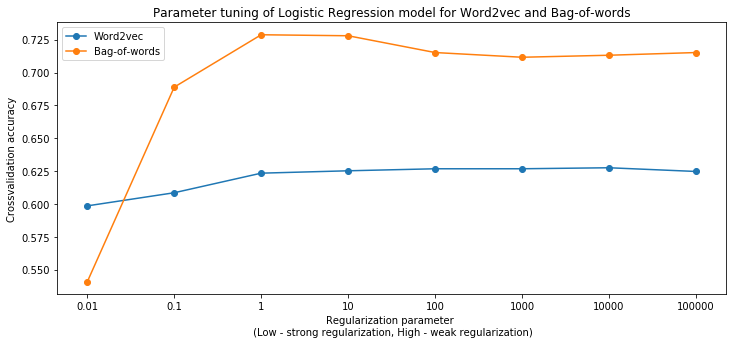

Logistic Regression model for Word2vec feature: C = 10000 have the highest crossvalidation accuracy 0.628.
Logistic Regression model for Bag-of-words feature: C = 1 have the highest crossvalidation accuracy 0.729.


In [43]:
# Plot the outcomes of cross-validation for Word2vec
plt.figure(figsize=(12, 5))
plt.plot(accs_word2vec, 'o-')
plt.plot(accs_bag_of_words, 'o-')
plt.xticks(range(len(grid)), grid)
plt.xlabel('Regularization parameter \n (Low - strong regularization, High - weak regularization)')
plt.ylabel('Crossvalidation accuracy')
plt.title('Parameter tuning of Logistic Regression model for Word2vec and Bag-of-words')
plt.legend(['Word2vec', 'Bag-of-words'])
plt.show()

# print highest crossvalidation accuracy
print('Logistic Regression model for Word2vec feature: C = {0} have the highest crossvalidation accuracy {1:.3f}.'.format(grid[np.argmax(accs_word2vec)], np.max(accs_word2vec)))
print('Logistic Regression model for Bag-of-words feature: C = {0} have the highest crossvalidation accuracy {1:.3f}.'.format(grid[np.argmax(accs_bag_of_words)], np.max(accs_bag_of_words)))

In [44]:
clf = LogisticRegression(random_state=42, solver='lbfgs', C = grid[np.argmax(accs_word2vec)]).fit(X_train_kv, y_train_kv)
print('The test accurancy of chosen Logistic Regression model for Word2vec feature is {:.3f}.'.format(clf.score(X_test_kv, y_test_kv)))
clf = LogisticRegression(random_state=42, solver='lbfgs', C = grid[np.argmax(accs_bag_of_words)]).fit(X_train_bw, y_train_bw)
print('The test accurancy of chosen Logistic Regression model for Word2vec Bag-of-words feature is {:.3f}.'.format(clf.score(X_test_bw, y_test_bw)))

The test accurancy of chosen Logistic Regression model for Word2vec feature is 0.642.
The test accurancy of chosen Logistic Regression model for Word2vec Bag-of-words feature is 0.709.


### 3.2 Neural Network
> [Neural Networks](https://en.wikipedia.org/wiki/Artificial_neural_network) (NN) are computing systems vaguely inspired by the biological neural networks that constitute animal brains. The neural network itself is not an algorithm, but rather a framework for many different machine learning algorithms to work together and process complex data inputs. Such systems "learn" to perform tasks by considering examples, generally without being programmed with any task-specific rules.

Simple linear classification schemes like logistic regression above can sometimes work well but they have their limits. The key to improving such schemes is to well choose features from the original data vector. Neural Network allows us to learn the such features from the data.

- Since, obviously, Bag-of-words features work much better than Word2vec features, here we **only consider Bag-of-words features**.
- As mentioned in slide, neural Network has very strong representation power. Even relatively simple nets (with at most **two hidden layers**) are capable of approximating any continous function arbitrarily closely. So, here we use **two hidden layers**.
- For output layer performing the actual ML task, since it's a **bi-classification problem**, we still use **logistic regression** model.
- `Epochs` is used to separate training into distinct phases and useful for periodic evaluation, more epochs you have, your model will be more fit to training set. We tune Epochs and activation functions to select best model.
- We try sequential neural network model with **dense layers**.

In [45]:
def NN_sequential_model(X, y, epochs, activation_function, test_size=0.1):
    '''
    Create sequential neural network model and tune activatio functions and epochs.
    
    Input:
        X, Y: list - Data of authors who have keyword vector feature.
        epochs: list - A list of epochs, which is used to separate training into distinct phases and useful for periodic evaluation.
        activation_function: list - Name of activation functions. 
        test_size: float - Proportion of test set.
        
    Return:
        score: float - Prediction accurancy score.
    '''
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    # Construct sequential model
    model = Sequential()
    
    # Two hidden layers
    model.add(Dense(64, input_dim=X_train.shape[1], activation=activation_function))
    # Dropout consists in randomly setting a fraction rate of input units to 0, which helps prevent overfitting.
    model.add(Dropout(0.5))
    model.add(Dense(64, activation=activation_function))
    model.add(Dropout(0.5))
    
    # Output layer performs the actual ML task, we still use logistic regression model.
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    # Fit NN model and evaluate the accurancy
    model.fit(X_train, y_train, epochs=epochs, batch_size=64, verbose=0)
    _, score = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
    return score

In [46]:
def plot_tune_DP(activation_function_list, epochs_list, score_dict):
    '''
        Visualization function for showing the processes of tuning parameter.
    '''
    plt.figure(figsize=(12, 5))
    for activation_function in activation_function_list:
        plt.plot(epochs_list, score_dict[activation_function], 'o-')
    plt.legend(activation_function_list)
    plt.title('Parameter tuning of neural networks model for Bag-of-words')
    plt.xlabel('Epochs')
    plt.ylabel('Test accurancy')
    plt.plot()

In [47]:
# List of parameters
activation_function_list = ['sigmoid', 'tanh', 'relu', 'softmax', 'linear', 'elu']
epochs_list = [10, 15, 20, 25, 30, 35]
score_dict = {}
# Tune parameters
for activation_function in activation_function_list:
    score_list = []
    for epochs in epochs_list:
        score_list.append(NN_sequential_model(X_bag_of_words, y_bag_of_words, epochs, activation_function))
    score_dict.update({activation_function: score_list})

Neural network model for Bag-of-words feature:
epoch = 10 and activation_function = elu have the highest test accuracy 0.743.


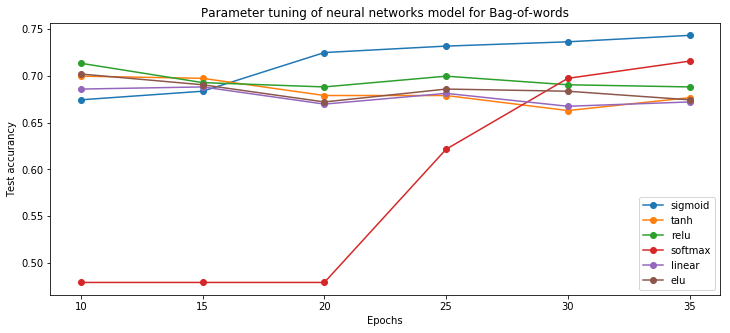

In [48]:
# with open('./Data/score_dict.pickle', 'wb') as handle:
#     pickle.dump(score_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('./data/score_dict.pickle', 'rb') as handle:
#     score_dict = pickle.load(handle)
# activation_function_list = ['sigmoid', 'tanh', 'relu', 'softmax', 'linear', 'elu']
# epochs_list = [10, 15, 20, 25, 30, 35]
plot_tune_DP(activation_function_list, epochs_list, score_dict)
max_row = int(np.argmax(np.array(list(score_dict.values()))) / 6)
max_column = np.argmax(np.array(list(score_dict.values()))) % 6
max_val = np.max(np.array(list(score_dict.values())))
epoch_max = epochs_list[max_row]
activation_function_max = activation_function_list[max_column]
print('Neural network model for Bag-of-words feature:\nepoch = {0} and activation_function = {1} have the highest test accuracy {2:.3f}.'.format(epoch_max, activation_function_max, max_val))

### 3.3 PCA and Neural network
> [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (entities each of which takes on various numerical values) into a set of values of linearly uncorrelated variables called principal components. PCA is mostly used as a tool in exploratory data analysis and for making predictive models.

- Principal component analysis is implemented before NN to reduce the order of features.
- We try sequential neural network model with 4 hidden layers and one output layer.
- We measure how the number of components kept and activation functions of hidden layer affect the performance.

In [49]:
# Load data
X = X_set1_fasttext.copy()
y = y_set1_fasttext.copy()

# test accuracy
te_accs = []
total_te_accs = []
# components for PCA
comp = [1,5,10,30,50,100,150,200,300]
for acf in ['sigmoid','tanh','relu','softmax','linear','elu']:
    te_accs = []
    for i in comp:
        # PCA to transform input data
        from sklearn.decomposition import PCA
        pca = PCA(n_components= i)
        pca.fit(X)
        X_pca = pca.fit_transform(X, y=None)
        # Split into training and test
        X_train, X_test, y_train, y_test = train_test_split(X_pca, np.asarray(y), test_size=0.2, random_state=1)
        #build a NN
        model = Sequential()
        model.add(Dense(256, input_dim=X_train.shape[1], activation=acf))
        model.add(Dense(128, activation=acf))
        model.add(Dense(64, activation=acf))
        model.add(Dense(32, activation=acf))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='rmsprop',
                      metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)
        score = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    
        te_accs.append(score[1])
    total_te_accs.append(te_accs)

In [50]:
# with open('./Data/total_te_accs.pickle', 'wb') as handle:
#     pickle.dump(total_te_accs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('./data/total_te_accs.pickle', 'rb') as handle:
#     total_te_accs = pickle.load(handle)

[]

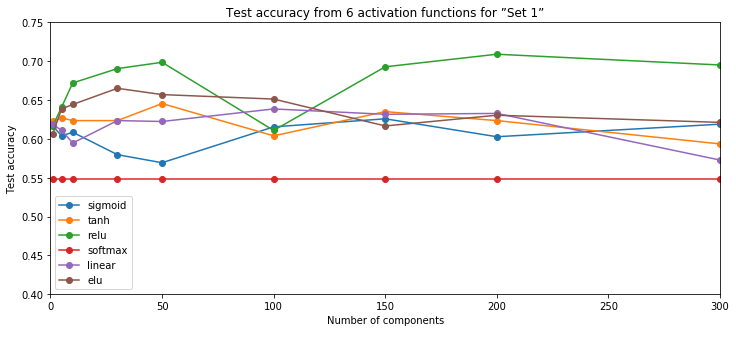

In [51]:
# Visulization
plt.figure(figsize=(12, 5))
# comp = [1,5,10,30,50,100,150,200,300]
plt.plot(comp,total_te_accs[0], 'o-')
plt.plot(comp,total_te_accs[1], 'o-')
plt.plot(comp,total_te_accs[2], 'o-')
plt.plot(comp,total_te_accs[3], 'o-')
plt.plot(comp,total_te_accs[4], 'o-')
plt.plot(comp,total_te_accs[5], 'o-')
plt.title('Test accuracy from 6 activation functions for ”Set 1”')
plt.xlabel('Number of components\n ')
plt.ylabel('Test accuracy')
plt.axis([0,300,0.4,0.75])
plt.legend(['sigmoid','tanh','relu','softmax','linear','elu'], loc = 'upperleft')
plt.plot()

In [52]:
def PCA_NN(X, y):
    # test accuracy
    te_accs = []
    # total_te_accs = []
    # components for PCA
    comp = [1,5,10,30,50,100,150,200,300]
    #for acf in ['sigmoid','tanh','relu','softmax','linear','elu']:
    te_accs = []
    for i in comp:
        # PCA to transform input data
        from sklearn.decomposition import PCA
        pca = PCA(n_components= i)
        pca.fit(X)
        X_pca = pca.fit_transform(X, y=None)
        # Split into training and test
        X_train, X_test, y_train, y_test = train_test_split(X_pca, np.asarray(y), test_size=0.2, random_state=1)
        #build a NN
        model = Sequential()
        model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                          optimizer='rmsprop',
                          metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)
        score = model.evaluate(X_test, y_test, batch_size=32, verbose=0)

        te_accs.append(score[1])
    return te_accs

In [53]:
te_accs_1 = PCA_NN(X_set1_fasttext, y_set1_fasttext)
te_accs_2 = PCA_NN(X_set2_fasttext, y_set2_fasttext)

[]

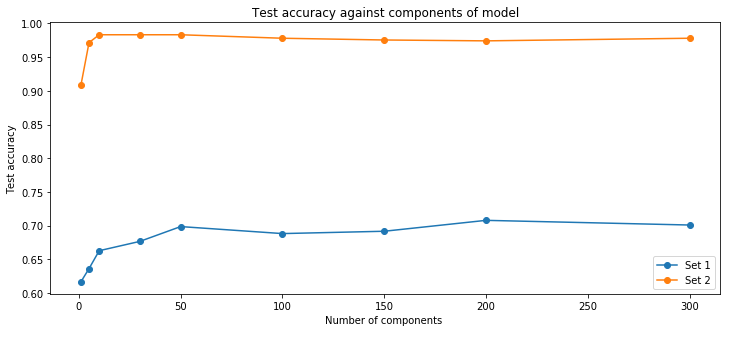

In [54]:
plt.figure(figsize=(12, 5))
plt.plot(comp, te_accs_1,'o-')
plt.plot(comp,te_accs_2,'o-')
plt.title('Test accuracy against components of model')
plt.xlabel('Number of components \n ')
plt.ylabel('Test accuracy')
plt.legend(['Set 1','Set 2'])
plt.plot()